In [1]:
from flash_ansr import FlashANSR, GenerationConfig, install_model, get_path
 
import torch
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
from drawdata import ScatterWidget

In [3]:
MODEL = "psaegert/flash-ansr-v21.0-60M"

In [4]:
install_model(MODEL)

Installing model psaegert/flash-ansr-v21.0-60M to /home/psaegert/Projects/flash-ansr/models/psaegert/flash-ansr-v21.0-60M


Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

Model psaegert/flash-ansr-v21.0-60M installed successfully!


In [9]:
nsr = FlashANSR.load(
    directory=get_path('models', MODEL),
    # generation_config=GenerationConfig(method='beam_search', beam_width=128 * 16, equivalence_pruning=True),
    # generation_config=GenerationConfig(method='softmax_sampling', choices=1024 * 32, max_len=32),
    generation_config=GenerationConfig(method='mcts', beam_width=128, simulations=1024 * 32),
    parsimony=0.02
).to(device)

In [10]:
widget = ScatterWidget()
widget

ScatterWidget()

In [12]:
X_raw, y_raw = widget.data_as_X_y

# Scale X_raw and y_raw to (-10, 10)
X = (X_raw - X_raw.min(axis=0)) / (X_raw.max(axis=0) - X_raw.min(axis=0)) * 20 - 10
y = (y_raw - y_raw.min(axis=0)) / (y_raw.max(axis=0) - y_raw.min(axis=0)) * 20 - 10

In [13]:
nsr.fit(X, y, verbose=True)

Fitting Constants: 100%|██████████| 128/128 [00:00<00:00, 847.57it/s]


In [14]:
nsr.compile_results(parsimony=0.02)

In [15]:
nsr.get_expression()

'-0.42 * (-1.24 + 24.17 * cos(2.02 - abs(0.48 * (2.07 + x1))))'

In [16]:
X_linspace = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)

In [17]:
y_pred = [[nsr.predict(X, nth_best_beam=beam_id, nth_best_constants=fit_id) for fit_id in range(len(result['fits'])) if np.isfinite(result['score'])] for beam_id, result in enumerate(nsr._results)]
y_pred_linspace = [[nsr.predict(X_linspace, nth_best_beam=beam_id, nth_best_constants=fit_id) for fit_id in range(len(result['fits'])) if np.isfinite(result['score'])] for beam_id, result in enumerate(nsr._results)]

/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/simplipy/operators.py:173: RuntimeWarning: invalid value encountered in power
  x = np.where(x < 0, -(-x) ** (1 / 5), x ** (1 / 5))
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/simplipy/operators.py:130: RuntimeWarning: invalid value encountered in power
  x = np.where(x < 0, -(-x) ** (1 / 3), x ** (1 / 3))


In [18]:
y_pred = y_pred[:32]
y_pred_linspace = y_pred_linspace[:32]

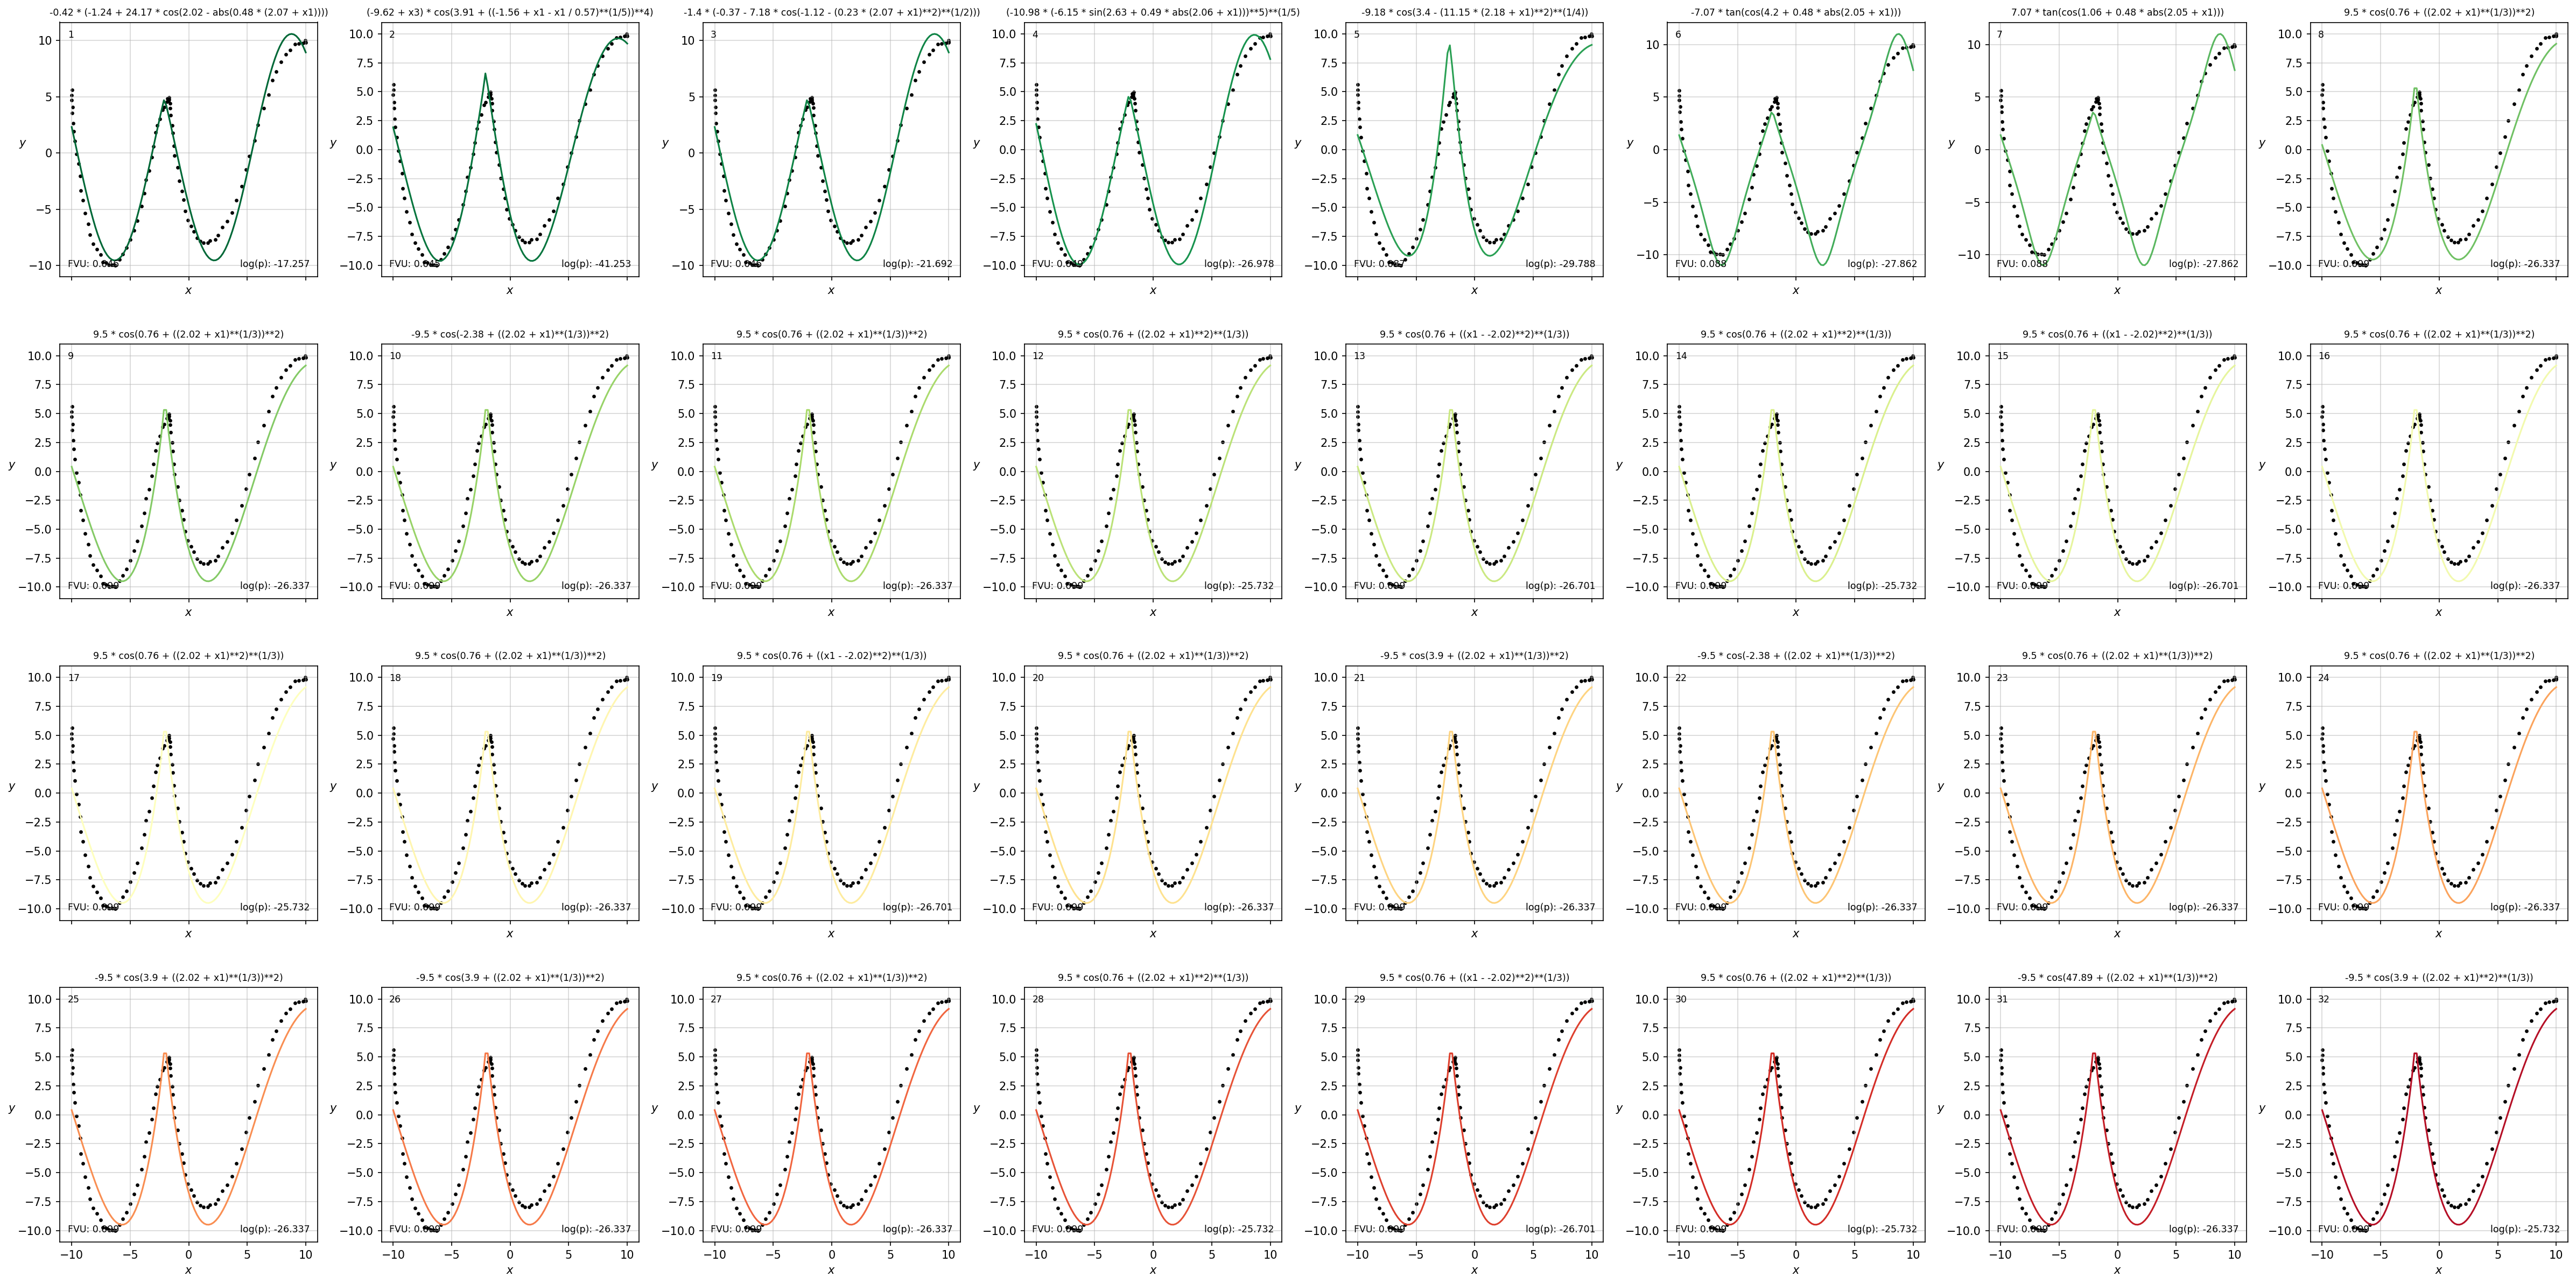

In [19]:
COLS = 8
ROWS = np.ceil(len(y_pred) / COLS).astype(int)

fig, axs = plt.subplots(ROWS, COLS, figsize=(COLS * 4, ROWS * 4), dpi=150, sharex=True)

for i, ax in enumerate(axs.flat):
    if i >= len(y_pred) or len(y_pred[i]) == 0:
        ax.axis('off')
        continue
    fvu = np.mean((y_pred[i][0][:, 0] - y)**2) / np.var(y)
    expression_pred_transformed = nsr._results[i]['refiner'].transform(nsr._results[i]['expression'], 0, return_prefix=True)
    expression_pred_transformed_infix = nsr.simplipy_engine.prefix_to_infix(expression_pred_transformed, power='**')

    ax.plot(X_linspace, y_pred_linspace[i][0], color=plt.get_cmap('RdYlGn')(1 - i / len(y_pred)))
    ax.scatter(X, y, color='k', s=5)
    ax.set_title(expression_pred_transformed_infix, fontsize='small')
    
    ax.annotate(f'{i + 1}', xy=(0.03, 0.97), xycoords='axes fraction', ha='left', va='top', fontsize='small')
    ax.annotate(f'FVU: {fvu:.3f}', xy=(0.03, 0.03), xycoords='axes fraction', ha='left', va='bottom', fontsize='small')
    ax.annotate(f'log(p): {nsr._results[i]["log_prob"]:.3f}', xy=(0.97, 0.03), xycoords='axes fraction', ha='right', va='bottom', fontsize='small')

    ax.grid(alpha=0.5)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$', rotation=0, labelpad=5)

fig.tight_layout(h_pad=3)

Text(0, 0.5, 'Log Probability')

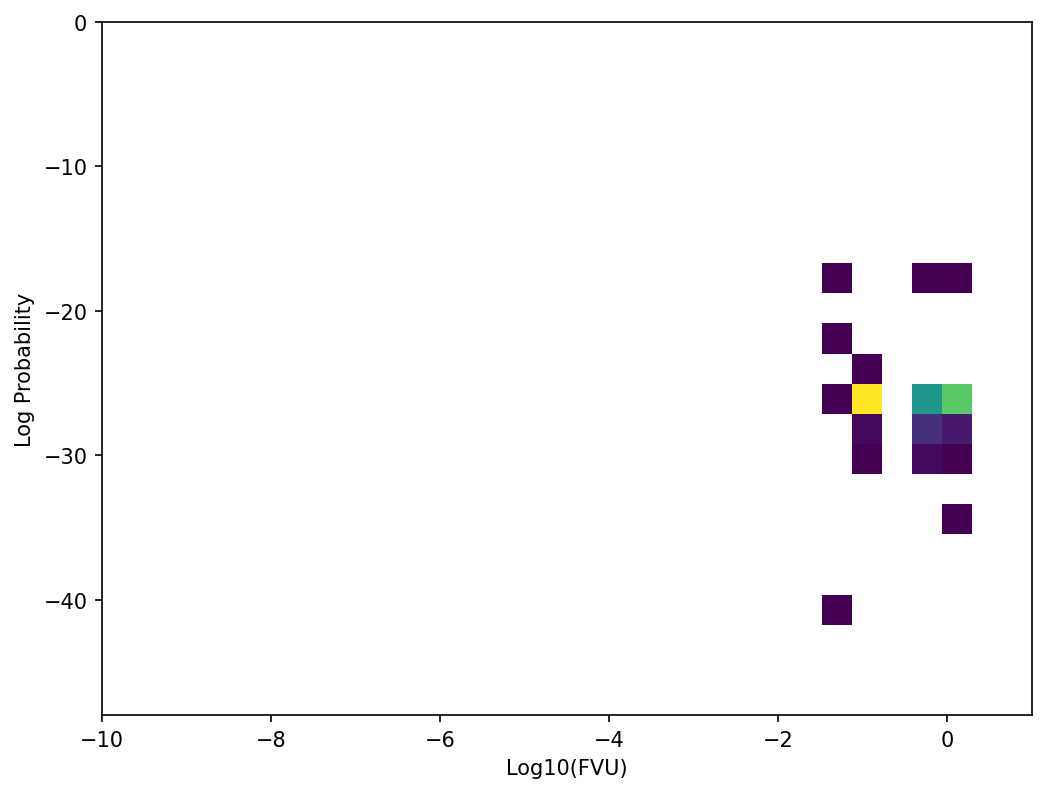

In [20]:
# plot the fvu against the complexity
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
ax.hist2d(np.log10(nsr.results['fvu']), nsr.results['log_prob'], bins=(np.linspace(-10, 1, 32), np.linspace(-48, 0, 24)), cmin=1);
ax.set_xlabel('Log10(FVU)')
ax.set_ylabel('Log Probability')

Text(0, 0.5, 'Log Probability')

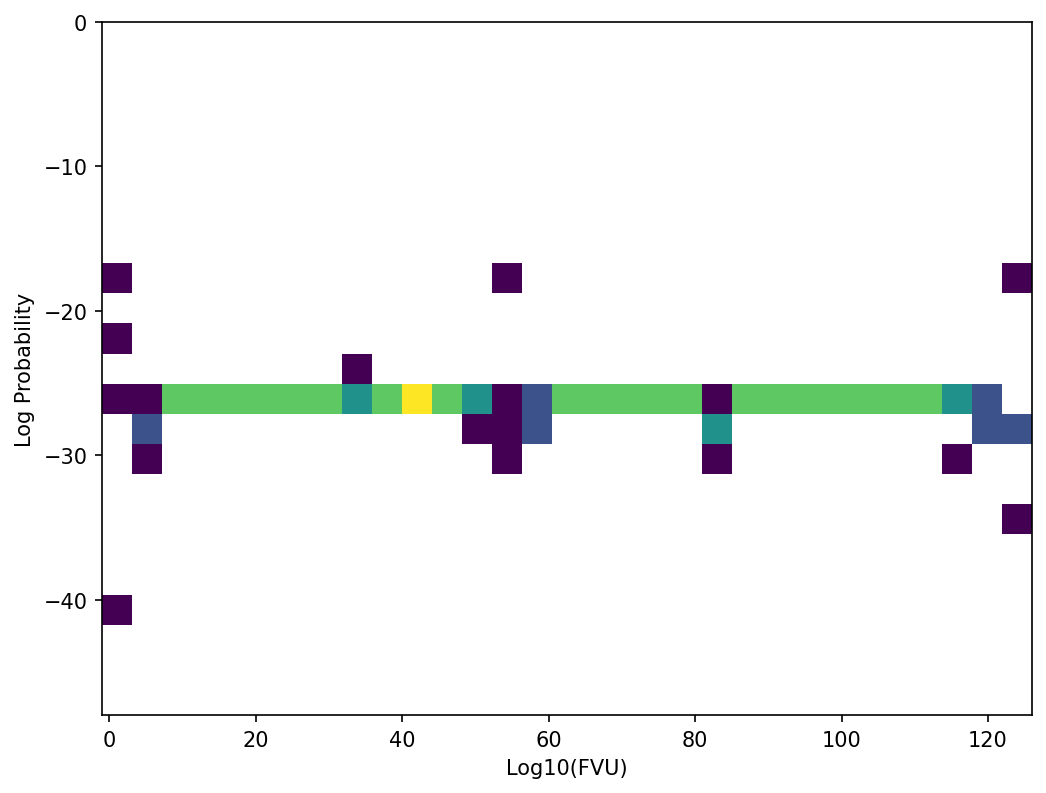

In [21]:
# plot the fvu against the complexity
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
ax.hist2d(np.argsort(nsr.results['fvu']), nsr.results['log_prob'], bins=(np.linspace(-1, len(nsr.results), 32), np.linspace(-48, 0, 24)), cmin=1);
ax.set_xlabel('Log10(FVU)')
ax.set_ylabel('Log Probability')

Text(0, 0.5, 'Complexity')

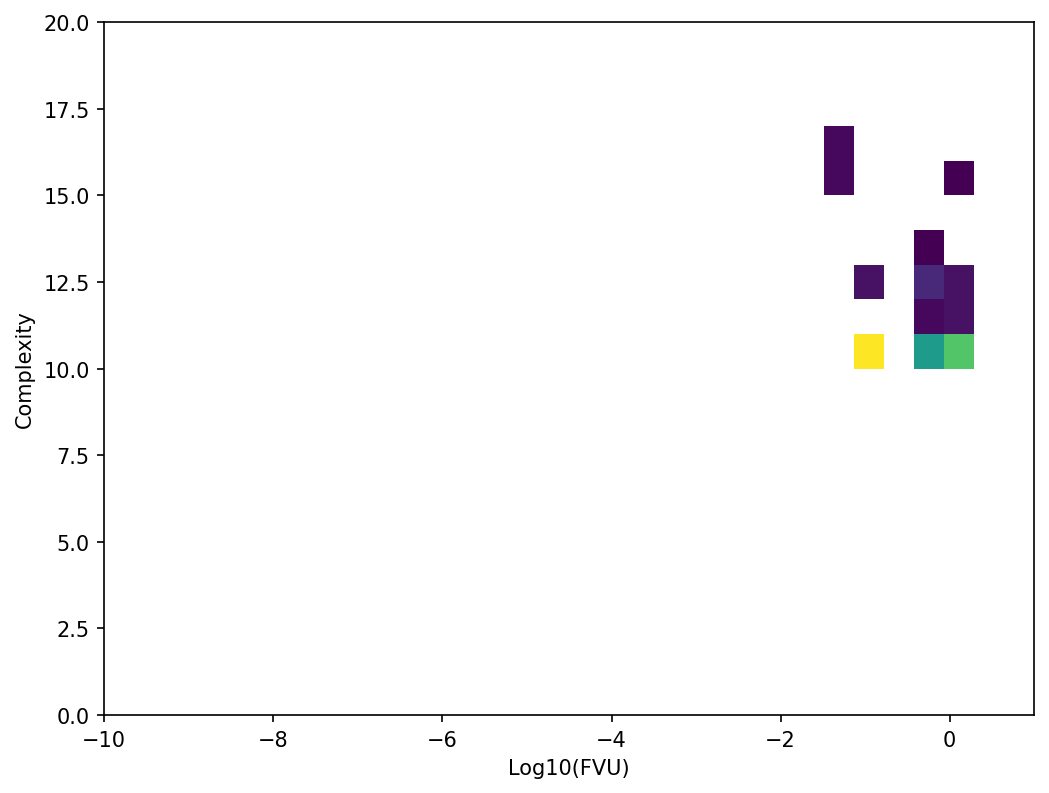

In [22]:
# plot the fvu against the complexity
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
ax.hist2d(np.log10(nsr.results['fvu']), nsr.results['complexity'], bins=(np.linspace(-10, 1, 32), np.linspace(0, 20, 21)), cmin=1);
ax.set_xlabel('Log10(FVU)')
ax.set_ylabel('Complexity')